<a href="https://colab.research.google.com/github/shlomosananes/YouTube_Project/blob/main/HACKATHON_YouTube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SET-UP**

## **Importing Libraries**

In [ ]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import os
import plotly.express as px
from datetime import datetime
from collections.abc import Iterable
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from plotnine import *
import string
from sklearn.preprocessing import OrdinalEncoder

## **Seeting Credentials for YouTube API**

In [ ]:
api_key1 = ''
api_key2 = ''
api_key3 = ''

#youtube = build('youtube','v3', developerKey = api_key)
youtube = build('youtube','v3', developerKey = api_key1)

--------

# **STEP 01 ------------------------------------------**

# **CATEGORIES**

## **01.01 - video_CATEGORIES**

### **Getting list of video_CATEGORIES**

In [ ]:
# Make the API request to retrieve channel categories for Israel
request = youtube.videoCategories().list(
    part='snippet',
    regionCode='IL'  # Use the region code for Israel
)

response = request.execute()

# Process the response to extract category IDs and titles
video_categories = []
for item in response.get('items', []):
    Category_id = item['id']
    Category = item['snippet']['title']
    video_categories.append({'Category_id': Category_id, 'Category': Category})

In [ ]:
categories = pd.DataFrame(video_categories)

In [ ]:
categories['Category_id'] = categories['Category_id'].astype(int)

In [ ]:
categories.sort_index()

,Category_id,Category
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports
5,18,Short Movies
6,19,Travel & Events
7,20,Gaming
8,21,Videoblogging
9,22,People & Blogs


## **01.02 - TOP VIDEOS**

### **YouTube TOP VIDEOS**

In [ ]:
def get_top_videos(youtube):

  all_data = []

  next_page_token = None
  limit = 0

  while limit < 10:

    request = youtube.videos().list(
        part="snippet",
        chart="mostPopular",
        maxResults=50,
        pageToken = next_page_token )

    response = request.execute()

    for i in range(len(response['items'])):

        data = dict(Video_id = response['items'][i]['id'],
                    Category_id = response['items'][i]['snippet']['categoryId'],
                    Title = response['items'][i]['snippet']['title'] ,
                    Description = response['items'][i]['snippet']['description'],
                    url_default = response['items'][i]['snippet']['thumbnails']['default']['url'],
                    Channel_id = response['items'][i]['snippet']['channelId'] ,
                    #Channel_title = response['items'][i]['snippet']['channelTitle'],
                    Publish_time = response['items'][i]['snippet']['publishedAt'])

        all_data.append(data)

    next_page_token = response.get('nextPageToken')

    if not next_page_token:
      break  # Break the loop if there are no more pages

    limit += 1

  return all_data

In [ ]:
### This code was used to pull new data and save.
### For the presentation I used the uploaded files

# top_videos = get_top_videos(youtube)

In [ ]:
### This code was used to pull new data and save.
### For the presentation I used the uploaded files
# Exporting results to gather and upload and concat afterwards

# top_videos_df.to_csv('top_videos_02.csv', index=False)

**MUST UPLOAD FILES TO CONTINUE**
- Files name: " top_videos_ .... "

In [ ]:
csv_files = [file for file in os.listdir() if file.endswith('.csv')]

top_videos_dfs = []

for file in csv_files:
    if file.startswith("top_videos"):
        df = pd.read_csv(file)
        top_videos_dfs.append(df)

combined_top_videos_df = pd.concat(top_videos_dfs, ignore_index=True)

In [ ]:
combined_top_videos_df.shape

(400, 7)

In [ ]:
combined_top_videos_df.duplicated().sum()

200

In [ ]:
combined_top_videos_df = combined_top_videos_df.drop_duplicates()

In [ ]:
combined_top_videos_df.duplicated().sum()

0

In [ ]:
combined_top_videos_df.shape

(200, 7)

**At this point the Combined_Top_Videos_DataFrame is ready.**

# **01.03 - Top videos ANALYSIS**

In [ ]:
cat_counts = combined_top_videos_df['Category_id'].value_counts(normalize=True) * 100
df_counts = cat_counts.reset_index()
df_counts.columns = ['Category_id', 'Frequency']

In [ ]:
categories_frequency = pd.merge(df_counts, categories, on = 'Category_id' , how ='left')

In [ ]:
fig = px.treemap(categories_frequency, path=['Category'], values='Frequency', color='Frequency', color_continuous_scale = 'Brwnyl')
fig.update_layout(title = 'Treemap of Categories Frequency in top 200 videos')
fig.show()

# **STEP 02 ------------------------------------------**

# **VIDEOS (based on Keywords and Cat.27)**

## **02.01 - KEYWORDS**

In [ ]:
# Define the search query
# Increasing the list of words that results not really change. It is always between 490 and 680.

# query 1: requests 01 02 03 04 05
query1 = 'tutorial|learning|lesson|practice|guide|Education|Training|How-to|Workshop|Course|Study|Skill|Lecture|Educational|Code|Coding|Programming|School|Professional|Improve|Learn'
# query 2: requests 06 07 08 09 10
query2 = 'datas cience | coding | programing | developer | code | chat gpt | python | tableau | power bi | looker | sql | tutorial '
# query 3: requests 11 12 13 14 15
query3 = ' Architect | Medicine | Engineering | Lawyer | Cooking | Economist | Politician | Journalism | Business | Gardening | Real State | Sales | Logistics | Manufacturing | Social Media'
# query 4: requests 16 17 18 19 20
query4 = ' Art | Sports | Meditation | Elderly | Day care | Mindedness | Religion | Music | Cinema | Parenthood | Masonry | Self awareness | Counselling '



## **02.02 - FUNCTION to fetch VIDEOS**

### **Function definition**

In [ ]:
# Create a YouTube Data API client
#youtube = build('youtube', 'v3', developerKey=api_key)
# Define the category IDs for educational content (You can find the full list of category IDs in the API documentation)
#category_ids = Educ_categories.video_cat_id  # Education and Science & Technology categories
# Define function to fetch data
def get_videos(youtube,query):

  all_data = []

  # Split category IDs into a list
  #category_id_list = category_ids.split(',')
  #for category_id in category_ids:
#Esses proximos #s sao soh para economziar QUOTES. As linhas precisam rodar no codigo

  next_page_token = None
  limit = 0

  while limit < 20:

    request = youtube.search().list(
          #q=query1,
          #q=query2,
          #q=query3,
          q=query4,
          part='snippet',
          type='video',
          videoCategoryId= '27',
          maxResults=50,  # You can adjust this number as needed
          pageToken = next_page_token
          )

    response = request.execute()

    for i in range(len(response['items'])):

        data = dict(Video_id = response['items'][i]['id']['videoId'],
                    Category_id = '27',
                    Title = response['items'][i]['snippet']['title'] ,
                    Description = response['items'][i]['snippet']['description'],
                    url_default = response['items'][i]['snippet']['thumbnails']['default']['url'],
                    Channel_id = response['items'][i]['snippet']['channelId'] ,
                    #Channel_title = response['items'][i]['snippet']['channelTitle'],
                    Publish_time = response['items'][i]['snippet']['publishTime'])

        all_data.append(data)
        print(f"Page {limit+1} - Item {limit*50+i+1}")

    next_page_token = response.get('nextPageToken')

    if not next_page_token:
      break  # Break the loop if there are no more pages

    limit += 1

  return all_data

### **Function call**

In [ ]:
### Used during development
### For the presentation I used the uploaded files

# videos_response = get_videos(youtube,query)

-------

## **02.03 - DataFrame Creation**

### **Files management**

In [ ]:
# # When using API

# recent_fetch = videos_response.copy()
# recent_fetch_df = pd.DataFrame(recent_fetch)
# # Exporting results to gather and upload and concat afterwards
# recent_fetch_df.to_csv('videos_df_20.csv', index=False)

In [ ]:
# Block to create a combined df with data from all the files uploaded

csv_files = [file for file in os.listdir() if file.endswith('.csv')]

videos_dfs = []

for file in csv_files:
    if file.startswith("videos_df"):
        df = pd.read_csv(file)
        videos_dfs.append(df)

combined_videos_df = pd.concat(videos_dfs, ignore_index=True)

In [ ]:
combined_videos_df.shape

(12111, 7)

In [ ]:
combined_videos_df.duplicated().sum()

9255

In [ ]:
combined_videos_df = combined_videos_df.drop_duplicates()

In [ ]:
combined_videos_df.duplicated().sum()

0

In [ ]:
combined_videos_df.shape

(2856, 7)

In [ ]:
videosdf = combined_videos_df.copy()

In [ ]:
videosdf.dtypes

Video_id        object
Category_id      int64
Title           object
Description     object
url_default     object
Channel_id      object
Publish_time    object
dtype: object

## **02.04 - Transforming data**

### **[ ' Publish Time ' ]**

In [ ]:
videosdf.Publish_time = pd.to_datetime(videosdf.Publish_time)

In [ ]:
for index, row in videosdf.iterrows():
     videosdf.loc[index, 'Publish_time'] = pd.to_datetime(row['Publish_time'])
     videosdf.loc[index, 'Publish_time'] = row['Publish_time'].replace(tzinfo=None)

In [ ]:
current_date = datetime.now()

In [ ]:
bins = [-1, 30, 180, 365, 730, 1825, 3650, float('inf')]
labels = ['0 to 1 month', '1 to 6 months', '6 months to 1 year', '1 year to 2 years', '2 years to 5 years', '5 years to 10 years', 'More than 10 years']

In [ ]:
for index, row in videosdf.iterrows():

    lifetime_days = (current_date - row['Publish_time']).days
    videosdf.loc[index, 'Life_days'] = lifetime_days

    years = lifetime_days // 365
    months = (lifetime_days % 365) // 30
    days = (lifetime_days % 365) % 30
    videosdf.loc[index, 'Life_string'] = f"{years}y {months}m {days}d"

    videosdf.loc[index, 'Life'] = pd.cut([lifetime_days], bins=bins, labels=labels)

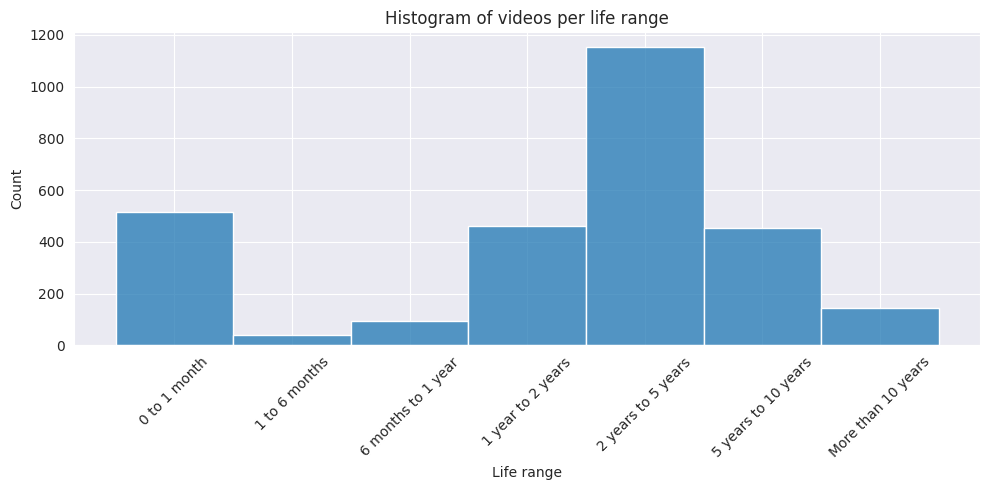

In [ ]:
plt.figure(figsize=(10,5))

sns.set_style('darkgrid')
sns.histplot(videosdf.Life)

plt.title("Histogram of videos per life range")
plt.xlabel("Life range")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***INSIGHTS:***
**Most of the EDUCATION videos fetched (probably due to the API mechanism) were released from 2 to 5 years before this analysis (April 2024). In the second position are recent videos released within less than one month before the data collection (what indicates the API returns recent videos possibly as an advertising strategy). If the data is was influenced by API definitions, we could assume the EDUCATION videos became more significant in the last 5 years, what is valid due to the changes the world has faced starting on Covid time, when people started doing more and more things online and at home, including learning.**

In [ ]:
videosdf.dtypes

Video_id          object
Category_id        int64
Title             object
Description       object
url_default       object
Channel_id        object
Publish_time      object
Life_days        float64
Life_string       object
Life            category
dtype: object

In [ ]:
videosdf.reset_index(drop=True, inplace=True)

# **STEP 03 ------------------------------------------**

# **VIDEOS details**

## **03.01 - Getting list of VIDEOS_id**

In [ ]:
videos_id_list_index = videosdf.Video_id.unique()

In [ ]:
videos_id_list = pd.Series(videos_id_list_index)

## **03.02 - Function to retrieve video DETAILS**

### **Function definition**

In [ ]:
# Retrieving additional information of videos
# Using endpoint (method) = youtube.videos().list(

def get_videos_info(youtube, videos_id_list):

    videos_info = []

    # Split the list of video IDs into chunks of 50 (maximum allowed by the API)
    for i in range(0, len(videos_id_list), 50):
        chunk_ids = ','.join(videos_id_list[i:i+50])

        # Make API request to fetch information for the specified video IDs
        request = youtube.videos().list(
            part='snippet,contentDetails,statistics',
            id=chunk_ids
        )
        response = request.execute()

        for i in range(len(response['items'])):

          data = dict(Video_id = response['items'][i]['id'],
                    Tags = response['items'][i]['snippet'].get('tags', None),
                    Localized_title = response['items'][i]['snippet']['localized']['title'],
                    Localized_description = response['items'][i]['snippet']['localized']['description'],
                    Default_language = response['items'][i]['snippet'].get('defaultAudioLanguage', None),

                    Duration = response['items'][i]['contentDetails']['duration'],
                    Caption = response['items'][i]['contentDetails']['caption'],

                    View_count = response['items'][i]['statistics']['viewCount'],
                    Like_count = response['items'][i]['statistics'].get('likeCount',"unavailable"),
                    Comment_count = response['items'][i]['statistics'].get('commentCount',"unavailable")
                    )

          videos_info.append(data)

    return videos_info

### **Function call**

In [ ]:
videos_details = get_videos_info(youtube, videos_id_list)

## **03.03 - DataFrame Creation**

### **From API**

In [ ]:
# When using API
df_videos_details = pd.DataFrame(videos_details)

In [ ]:
df_videos_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Video_id               2851 non-null   object
 1   Tags                   2427 non-null   object
 2   Localized_title        2851 non-null   object
 3   Localized_description  2851 non-null   object
 4   Default_language       2263 non-null   object
 5   Duration               2851 non-null   object
 6   Caption                2851 non-null   object
 7   View_count             2851 non-null   object
 8   Like_count             2851 non-null   object
 9   Comment_count          2851 non-null   object
dtypes: object(10)
memory usage: 222.9+ KB


In [ ]:
# Exporting results of videos details
df_videos_details.to_csv('df_videos_details.csv', index=False)

### **From File**

In [ ]:
### This request is not so heavy and can be performed only once so I won't download and upload files
### Importing data from file

# df_videos_details = pd.read_csv('df_videos_details.csv')

## **03.04 - Merging details into original DataFrame**

In [ ]:
df_videos_with_details = pd.merge(videosdf, df_videos_details, on = 'Video_id' , how ='left')

In [ ]:
df_videos_with_details.shape

(2856, 19)

In [ ]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [ ]:
df_videos = df_videos_with_details.copy()

# **STEP 04 ------------------------------------------**

# **Data Preprocessing**

## **04.01 - Missing Values**

In [ ]:
missing_data_count = df_videos.isnull().sum()
print(missing_data_count)

Video_id                   0
Category_id                0
Title                      0
Description               85
url_default                0
Channel_id                 0
Publish_time               0
Life_days                  0
Life_string                0
Life                       0
Tags                     427
Localized_title            3
Localized_description      3
Default_language         591
Duration                   3
Caption                    3
View_count                 3
Like_count                 3
Comment_count              3
dtype: int64


In [ ]:
df_videos = df_videos.dropna(subset=['Duration'])

In [ ]:
columns_null = df_videos.isnull().sum().sort_index()
columns_with_null = columns_null[columns_null > 0]
columns_with_null

Default_language    588
Description          85
Tags                424
dtype: int64

- [ ' Description ' ] will be excluded. We will work with [ ' localized_description ' ]
- [ ' Default_language ' ] will remain empty.
- [ ' Tags ' ] will remain empty.


## **04.02 - Transforming Columns**

### **[ ' Duration ' ]**

In [ ]:
df_videos['Duration'] = pd.to_timedelta(df_videos['Duration'])

# Convert Timedelta objects to minutes
df_videos['Duration_minutes'] = df_videos['Duration'].dt.total_seconds() / 60
df_videos['Duration_minutes'] = df_videos['Duration_minutes'].round(1)

In [ ]:
bins = [0, 5, 20, 60, 120, 300, float('inf')]
labels = ['0-5 min', '5-20 min', '20m to 1h', '1-2h', '2-5h', '>5h']

In [ ]:
df_videos['Duration_range'] = pd.cut(df_videos['Duration_minutes'], bins=bins, labels=labels, right=False)

### **[ ' Like_count ' ]**

In [ ]:
# def format_with_thousands_separator(num):
#     return '{:,.0f}'.format(num)

In [ ]:
df_videos['Like_count'] = pd.to_numeric(df_videos['Like_count'], errors='coerce')
df_videos['Like_count'].fillna(0, inplace=True)

In [ ]:
duration_likes = df_videos.groupby('Duration_range')['Like_count'].sum()

In [ ]:
duration_likes = duration_likes.reset_index()

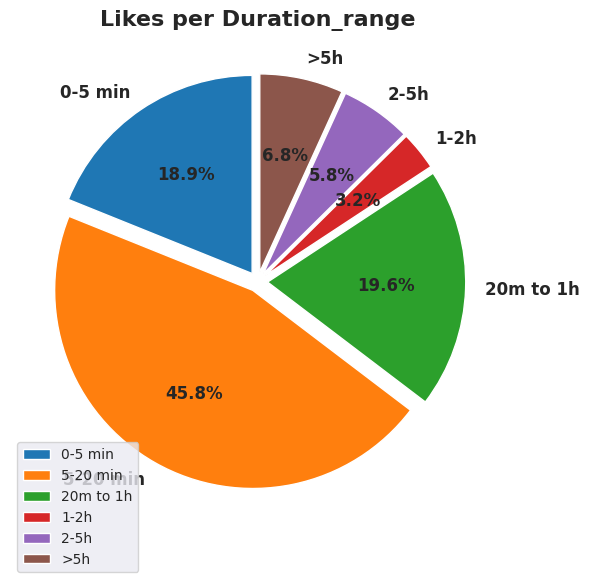

In [ ]:
explode = [0.05] * len(duration_likes)

sns.set_style("dark")
plt.figure(figsize=(6,6))
plt.pie(duration_likes['Like_count'] , labels = duration_likes['Duration_range'], autopct='%1.1f%%', startangle=90, explode=explode,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Likes per Duration_range', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend(duration_likes['Duration_range'], loc='lower left', bbox_to_anchor=(0, -0.1))
plt.tight_layout()
plt.show()

***INSIGHTS:***
**We can conclude from the chart that short videos are more appreciated by the viewers. The videos with most likes are those with duration between 5 and 20 minutes, followed by 20m-1hour and 0-5min.**

### **[ ' View_count ' ] & [ ' Comment_count ' ]**

In [ ]:
df_videos['View_count'] = pd.to_numeric(df_videos['View_count'], errors='coerce')
df_videos['View_count'].fillna(0, inplace=True)
df_videos['View_count'] = df_videos['View_count'].astype(int)

df_videos['Comment_count'] = pd.to_numeric(df_videos['Comment_count'], errors='coerce')
df_videos['Comment_count'].fillna(0, inplace=True)
df_videos['Comment_count'] = df_videos['Comment_count'].astype(int)

### **[ ' Likes_per_view ' ] & [ ' Comments_per_view ' ]**

In [ ]:
df_videos['Likes_per_day'] = df_videos['Like_count'] / df_videos['Life_days']
df_videos['Likes_per_view'] = df_videos['Like_count'] / df_videos['View_count']

df_videos['Views_per_day'] = df_videos['View_count'] / df_videos['Life_days']

df_videos['Comments_per_day'] = df_videos['Comment_count'] / df_videos['Life_days']
df_videos['Comments_per_view'] = df_videos['Comment_count'] / df_videos['View_count']

### **[ ' Caption ' ]**

In [ ]:
df_videos.Caption.value_counts()

Caption
false    2209
true      644
Name: count, dtype: int64

In [ ]:
ode = OrdinalEncoder()
df_videos['Caption_ode'] = ode.fit_transform(df_videos[['Caption']])

In [ ]:
df_videos.Caption_ode.value_counts()

Caption_ode
0.0    2209
1.0     644
Name: count, dtype: int64

## **04.03 - Columns Removal**

In [ ]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2853 entries, 0 to 2855
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Video_id               2853 non-null   object         
 1   Category_id            2853 non-null   int64          
 2   Title                  2853 non-null   object         
 3   Description            2768 non-null   object         
 4   url_default            2853 non-null   object         
 5   Channel_id             2853 non-null   object         
 6   Publish_time           2853 non-null   object         
 7   Life_days              2853 non-null   float64        
 8   Life_string            2853 non-null   object         
 9   Life                   2853 non-null   category       
 10  Tags                   2429 non-null   object         
 11  Localized_title        2853 non-null   object         
 12  Localized_description  2853 non-null   object        

In [ ]:
columns_to_exclude = ['Title', 'Description', 'url_default']
df_videos.drop(columns=columns_to_exclude, inplace=True)

In [ ]:
df_videos.insert(1, 'Title', df_videos.pop('Localized_title'))
df_videos.insert(2, 'Description', df_videos.pop('Localized_description'))
df_videos.insert(12, 'Duration_minutes', df_videos.pop('Duration_minutes'))
df_videos.insert(13, 'Duration_range', df_videos.pop('Duration_range'))
df_videos.insert(15, 'Caption_ode ', df_videos.pop('Caption_ode'))

In [ ]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2853 entries, 0 to 2855
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Video_id           2853 non-null   object         
 1   Title              2853 non-null   object         
 2   Description        2853 non-null   object         
 3   Category_id        2853 non-null   int64          
 4   Channel_id         2853 non-null   object         
 5   Publish_time       2853 non-null   object         
 6   Life_days          2853 non-null   float64        
 7   Life_string        2853 non-null   object         
 8   Life               2853 non-null   category       
 9   Tags               2429 non-null   object         
 10  Default_language   2265 non-null   object         
 11  Duration           2853 non-null   timedelta64[ns]
 12  Duration_minutes   2853 non-null   float64        
 13  Duration_range     2853 non-null   category       
 1

## **04.04 - Missing Values 2**

In [ ]:
columns_null = df_videos.isnull().sum().sort_index()
columns_with_null = columns_null[columns_null > 0]
columns_with_null

Comments_per_view      8
Default_language     588
Likes_per_view         8
Tags                 424
dtype: int64

In [ ]:
df_videos['Comments_per_view'] = df_videos['Comments_per_view'].fillna(0)
df_videos['Likes_per_view'] = df_videos['Likes_per_view'].fillna(0)

In [ ]:
columns_null = df_videos.isnull().sum().sort_index()
columns_with_null = columns_null[columns_null > 0]
columns_with_null

Default_language    588
Tags                424
dtype: int64

# **STEP 05 ------------------------------------------**

# **THEME**

## **05.01 - FUNCTIONS**

### **Function Remove Emojis**

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

### **Function Unite Words**

In [ ]:
# Define the dictionary containing word pairs and their replacements
word_pairs = {
    'chat gpt': 'chatgpt',
    'chatgpt' : 'chatgpt',
    'bigdata': 'bigdata',
    'data science' : 'datascience',
    'big data': 'bigdata',
    'power bi': 'powerbi',
    'powerbi': 'powerbi',
    'git hub': 'github',
    'github': 'github',
    'cyber security': 'cybersecurity',
    'cybersecurity': 'cybersecurity',
    'crypto currency': 'cryptocurrency',
    'cryptocurrency': 'cryptocurrency',
    'social media marketing': 'socialmediamarketing',
    'social media': 'socialmedia',
    'clean up': 'cleanup',
    'guitar lesson': 'guitarlessons',
    'guitar lessons': 'guitarlessons',
    'guitarlesson': 'guitarlessons',
    'guitarlessons': 'guitarlessons',
    'toddler learn': 'toddlerlearning',
    'toddlerlearn': 'toddlerlearning',
    'toddler learning': 'toddlerlearning',
    'toddlerlearning': 'toddlerlearning',
    'child development': 'childdevelopment',
    'childdevelopment': 'childdevelopment',
    'child develop': 'childdevelopment',
    'childdevelop': 'childdevelopment',
    'universal desing for learning': 'universaldesignforlearning',
    'udl': 'universal-designforlearning',
    'graphic design': 'graphicdesign',
    'graphicdesign': 'graphicdesign',
    'final cut' : 'finalcut',
    'art for kids' : 'artforkids',
    'bullet journal' : 'bulletjournal',
    'self awareness' : 'selfawareness',
    'make money' : 'make money',
    'delta exchange' : 'deltaexchange',
    'data analyst' : 'dataanalyst',
    'get subscribers' : 'getsubscribers',
    'overcome trauma' : 'overcometrauma',
    'research proposal' : 'research proposal',
    'zoom webinar' : 'zoomwebinar',
    'love yourself' : 'loveyourself',
    'education game' : 'educationgame',
    'data drive' : 'datadriven',
    'body language' : 'bodylanguage',
    'personal growth' : 'personalgrowth',
    'mental health' : 'mentalhealth',
    'real estate' : 'realestate',
    'online business' : 'online business'
}

In [ ]:
def unite_words(string_to_transform, word_pairs):

    for pair, replacement in word_pairs.items():
        string_to_transform = string_to_transform.replace(pair, replacement)
    return string_to_transform

### **Function Most Common**

In [ ]:
irrelevantwords = ['a','an','and','the','these','those', 'one',
                   'of','to','for',
                   'in','at','on',
                   'is', 'are',
                   'i', 'you', 'your', 'we', 'they', 'our',
                   'way','ways','part', 'new',
                   'how', 'why', 'what', 'which',
                   'like','become','with',
                   'beginner','beginners','intermediate','advanced','pro',
                   'listening','listen','reading','read','writing','write','speaking','speak',
                   'learning','learn','tutorial','lesson','course','practice','exercise','training','train','exercises','guide','complete','advice',
                   'now','quickly','fast',
                   'https','http','https:','http:','www','com']

In [ ]:
exclude = string.punctuation

def remove_points(text):
    translator = str.maketrans('', '', exclude)
    text_without_punctuation = text.translate(translator)
    return text_without_punctuation

In [ ]:
def longest_word(bigstring):
    longest = ""
    for word in bigstring:
        # Split the string into words
        words = word.split()
        # Iterate over the words and find the longest
        for w in words:
            if len(w) > len(longest):
                longest = w
    return longest

In [ ]:
def most_common(word):
        counter = []
        dif_elements = []
        count_words = []
        my_string = word.split()
        elements = len(my_string)

        for i in range(elements):
            if (my_string[i] not in dif_elements) & (my_string[i] not in irrelevantwords):
                dif_elements.append(my_string[i])
        dif_elements.sort()
        different_words = len(dif_elements)

        for i in range(different_words):
            count_words.append(my_string.count(dif_elements[i]))
        counter = list(zip(count_words, dif_elements))
        counter.sort(key=lambda x: x[0], reverse =True)

        if len(counter) == 0:  # Check if counter is empty
          return 'Irrelevant'  # Return empty string if no words found

        max_count = counter[0][0]
        max_count_words = []

        if max_count == 1:
          return "Irrelevant"

        else:

          for i in range(different_words):
              if counter[i][0] == max_count:
                  max_count_words.append(counter[i][1])

          if len(max_count_words) > 1:
             return longest_word(max_count_words)
          else:
             return max_count_words[0]

## **05.02 - [ ' Tags ' ]**

In [ ]:
# Transform TAGs from list to single STRING

for index, row in df_videos.iterrows():
  if (not row['Tags']) | (isinstance(row['Tags'], Iterable) == False):
    df_videos.loc[index, 'Tags_separated'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Tags_separated'] = " ".join(row['Tags'])

In [ ]:
# Removing Emojis

for index, row in df_videos.iterrows():
  if row['Tags_separated'] == "Irrelevant":
    df_videos.loc[index, 'Tags_without_emojis'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Tags_without_emojis'] = remove_emojis(row['Tags_separated'])

In [ ]:
# NEW Removing punctuation

for index, row in df_videos.iterrows():
  if row['Tags_without_emojis'] == "Irrelevant":
    df_videos.loc[index, 'Tags_without_punctuation'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Tags_without_punctuation'] = remove_points(row['Tags_without_emojis']).lower().replace('[^a-zA-Z0-9]',' ')

In [ ]:
# Applying Function Unite Words

for index, row in df_videos.iterrows():
  if row['Tags_without_punctuation'] == "Irrelevant":
    df_videos.loc[index, 'Tags_united'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Tags_united'] = unite_words(row['Tags_without_punctuation'], word_pairs)

## **05.03 - [ ' Title ' ]**

In [ ]:
# Removing Emojis

for index, row in df_videos.iterrows():
  if row['Title']:
    df_videos.loc[index, 'Title_without_emojis'] = remove_emojis(str(row['Title']))

In [ ]:
# NEW Removing punctuation

for index, row in df_videos.iterrows():
  if row['Title_without_emojis'] == "Irrelevant":
    df_videos.loc[index, 'Title_without_punctuation'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Title_without_punctuation'] = remove_points(row['Title_without_emojis']).lower().replace('[^a-zA-Z0-9]',' ')

In [ ]:
# Applying Function Unite Words

for index, row in df_videos.iterrows():
  if row['Title_without_punctuation'] == "Irrelevant":
    df_videos.loc[index, 'Title_united'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Title_united'] = unite_words(row['Title_without_punctuation'], word_pairs)

## **05.04 - [ ' Description ' ]**

In [ ]:
# Remobing Emojis

for index, row in df_videos.iterrows():
  if (not row['Description']) | (str(row['Description']).strip() == ''):
    df_videos.loc[index, 'Description_without_emojis'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Description_without_emojis'] = remove_emojis(str(row['Description']))

In [ ]:
# NEW Removing punctuation

for index, row in df_videos.iterrows():
  if row['Description_without_emojis'] == "Irrelevant":
    df_videos.loc[index, 'Description_without_punctuation'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Description_without_punctuation'] = remove_points(row['Description_without_emojis']).lower().replace('[^a-zA-Z0-9]',' ')

In [ ]:
# Applying Function Unite Words

for index, row in df_videos.iterrows():
  if row['Description_without_punctuation'] == "Irrelevant":
    df_videos.loc[index, 'Description_united'] = "Irrelevant"
  else:
    df_videos.loc[index, 'Description_united'] = unite_words(row['Description_without_punctuation'], word_pairs)

## **05.05 - Defining options and final Theme**

### **Options**

In [ ]:
# From Tags

for index, row in df_videos.iterrows():
  if  row['Tags_united'] == "Irrelevant":
    df_videos.loc[index, 'Theme_from_Tags'] = "Irrelevant"
  elif len(row['Tags_united'].split()) == 1:
    df_videos.loc[index, 'Theme_from_Tags'] = row['Tags_united']
  else:
    df_videos.loc[index, 'Theme_from_Tags'] = most_common(str((row['Tags_united'])))

In [ ]:
# From Title

for index, row in df_videos.iterrows():
  if  row['Title_united'] == "Irrelevant":
    df_videos.loc[index, 'Theme_from_Title'] = "Irrelevant"
  elif len(row['Title_united'].split()) == 1:
    df_videos.loc[index, 'Theme_from_Title'] = row['Title_united']
  else:
    df_videos.loc[index, 'Theme_from_Title'] = most_common(str((row['Title_united'])))

In [ ]:
# From Description

for index, row in df_videos.iterrows():
  if  row['Description_united'] == "Irrelevant":
    df_videos.loc[index, 'Theme_from_Description'] = "Irrelevant"
  elif len(row['Description_united'].split()) == 1:
    df_videos.loc[index, 'Theme_from_Description'] = row['Description_united']
  else:
    df_videos.loc[index, 'Theme_from_Description'] = most_common(str((row['Description_united'])))

In [ ]:
# Based on NEW STRING

for index, row in df_videos.iterrows():
    New_string = (' '.join([row['Tags_united'], row['Title_united'], row['Description_united']])).strip('Irrelevant').strip()
    df_videos.loc[index, 'Theme_from_new_string'] = most_common(New_string)

## **05.06 - THEME FINAL DEFINITION**

In [ ]:
for index, row in df_videos.iterrows():

  if  row['Theme_from_Tags'] != "Irrelevant":
    df_videos.loc[index, 'Theme'] = row['Theme_from_Tags']
    df_videos.loc[index, 'Theme_source'] = "Tags"

  elif (not row['Theme_from_Description'] == False) & (row['Theme_from_Description'] != "Irrelevant"):
    df_videos.loc[index, 'Theme'] = row['Theme_from_Description']
    df_videos.loc[index, 'Theme_source'] = "Description"

  elif (not row['Theme_from_Title'] == False) & (row['Theme_from_Title'] != "Irrelevant"):
    df_videos.loc[index, 'Theme'] = row['Theme_from_Title']
    df_videos.loc[index, 'Theme_source'] = "Title"

  elif row['Theme_from_new_string']:
    df_videos.loc[index, 'Theme'] = row['Theme_from_new_string']
    df_videos.loc[index, 'Theme_source'] = "Concat_string"

  else:
    df_videos.loc[index, 'Theme'] = "Undefined"
    df_videos.loc[index, 'Theme_source'] = "?"

In [ ]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2853 entries, 0 to 2855
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype          
---  ------                           --------------  -----          
 0   Video_id                         2853 non-null   object         
 1   Title                            2853 non-null   object         
 2   Description                      2853 non-null   object         
 3   Category_id                      2853 non-null   int64          
 4   Channel_id                       2853 non-null   object         
 5   Publish_time                     2853 non-null   object         
 6   Life_days                        2853 non-null   float64        
 7   Life_string                      2853 non-null   object         
 8   Life                             2853 non-null   category       
 9   Tags                             2429 non-null   object         
 10  Default_language                 2265 non-null   obje

In [ ]:
columns_to_exclude = ['Tags_separated','Tags_without_emojis','Tags_without_punctuation','Tags_united','Theme_from_Tags',
                      'Title_without_emojis','Title_without_punctuation','Title_united','Theme_from_Title',
                      'Description_without_emojis','Description_without_punctuation','Description_united','Theme_from_Description',
                      'Theme_from_new_string']
df_videos.drop(columns=columns_to_exclude, inplace=True)

In [ ]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2853 entries, 0 to 2855
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Video_id           2853 non-null   object         
 1   Title              2853 non-null   object         
 2   Description        2853 non-null   object         
 3   Category_id        2853 non-null   int64          
 4   Channel_id         2853 non-null   object         
 5   Publish_time       2853 non-null   object         
 6   Life_days          2853 non-null   float64        
 7   Life_string        2853 non-null   object         
 8   Life               2853 non-null   category       
 9   Tags               2429 non-null   object         
 10  Default_language   2265 non-null   object         
 11  Duration           2853 non-null   timedelta64[ns]
 12  Duration_minutes   2853 non-null   float64        
 13  Duration_range     2853 non-null   category       
 1

## **05.07 - Validation**

In [ ]:
df_videos['Theme'].value_counts()

Theme
python         182
socialmedia    148
Irrelevant      68
powerbi         53
meditation      51
              ... 
onion            1
prong            1
cubic            1
steak            1
brahmcharya      1
Name: count, Length: 1218, dtype: int64

In [ ]:
theme_df = df_videos.copy()

## **05.08 - Theme ANALYSIS**

In [ ]:
theme_df['Theme'].value_counts()

Theme
python         182
socialmedia    148
Irrelevant      68
powerbi         53
meditation      51
              ... 
onion            1
prong            1
cubic            1
steak            1
brahmcharya      1
Name: count, Length: 1218, dtype: int64

In [ ]:
text = theme_df['Theme'].str.cat(sep=' ')

In [ ]:
stopwords = set(STOPWORDS)
new_stopwords = stopwords.union(irrelevantwords)

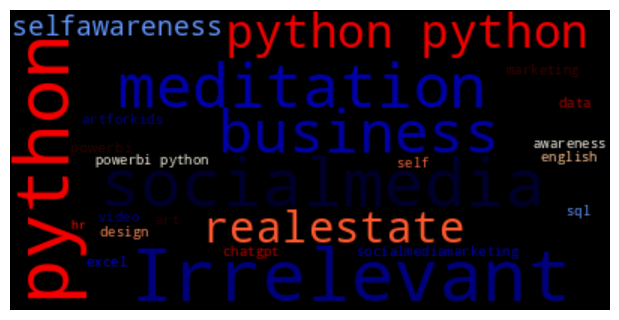

In [ ]:
plt.rcParams["figure.figsize"] = (6, 3)

wordcloud = WordCloud(max_font_size = 50, max_words = 25 , background_color = 'black' , stopwords = new_stopwords , colormap = 'flag').generate(text)

plt.plot()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

***INSIGHTS:***
**From the total of 2853 videos analysed, the used algorithm found 1218 likely themes. One of this is present as IRRELEVANT that actually means the algorithm failed to find a specific theme. The other 1217 themes appear with different occurrences, starting from 182 occurrences of PYTHON , 148 of SOCIAL MEDIA, 53 of POWER BI, 51 of MEDIDATION. The most common THEMES can be seen in the WordCloud above.**

**Pareto Chart**

In [ ]:
video_theme = theme_df['Theme']
theme_count = theme_df['Theme'].value_counts()
theme_keys = theme_count.keys()
theme_freq = theme_count.values

theme_freq_df = pd.DataFrame({'Theme': theme_keys, 'Frequency':theme_freq})
theme_freq_df['Percent'] = theme_freq_df.Frequency/theme_freq_df.Frequency.sum()*100
theme_freq_df = theme_freq_df.sort_values(by=['Frequency'], ascending=False)
theme_freq_df = theme_freq_df.reset_index(drop=True)
theme_freq_df['Cumulative_Percent'] = theme_freq_df.Frequency.cumsum() / theme_freq_df.Frequency.sum() * 100

In [ ]:
theme_freq_df = theme_freq_df.head(15)

<ipython-input-162-e3006fefd0c5>:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



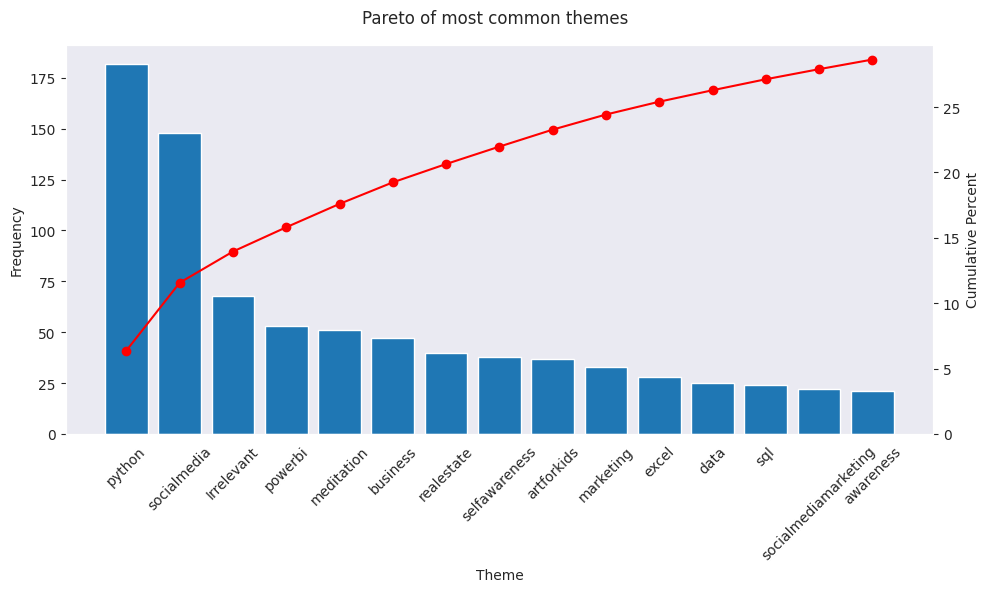

In [ ]:
fig,ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Theme')
ax.bar('Theme', 'Frequency', data = theme_freq_df)
ax.set_ylabel("Frequency")
ax.set_ylim(ymin=0)
ax.set_xticklabels(theme_freq_df['Theme'], rotation=45)  # Rotate x-axis labels by 45 degrees

ax2=ax.twinx()
ax2.plot('Theme', 'Cumulative_Percent' , data = theme_freq_df , marker = 'o' , color='red')
ax2.set_ylabel('Cumulative Percent')
ax2.set_ylim(ymin=0)

plt.suptitle('Pareto of most common themes')
plt.tight_layout()
plt.show()

***INSIGHTS:***
**The Pareto Theorem states that a small percentage of causes have an outsized effect, what can be confirmed here in this analysis where only 15 themes (1,23% of the 1218 themes found) respond by almost 30% of the videos fetched.**

------

# **STEP 06 ------------------------------------------**

# **CHANNELS**

## **06.01 - Getting list of CHANNELS**

In [ ]:
channels_list = theme_df.Channel_id.unique()

In [ ]:
channels_list = pd.Series(channels_list)

In [ ]:
channels_list.shape

(1801,)

## **06.02 - Fetching CHANNELS details**

### **Function definition**

In [ ]:

def get_channels_details(youtube, channels_list):

  all_data = []

  for channel in channels_list:

    request = youtube.channels().list(
      part = 'snippet,contentDetails,statistics',
      id = channel)

    response = request.execute()

    for item in range(len(response['items'])):
        data = dict(
            Channel_id = response['items'][item]['id'],
            Channel_title = response['items'][item]['snippet']['title'],
            Channel_country = response['items'][item]['snippet'].get('country', '*Not_found*'),
            Channel_viewCount = response['items'][item]['statistics']['viewCount'],
            Channel_subscriberCount = response['items'][item]['statistics']['subscriberCount'],
            Channel_videoCount = response['items'][item]['statistics']['videoCount']
            )

        all_data.append(data)

  return all_data

### **Function call**

In [ ]:
channels_data = get_channels_details(youtube, channels_list)

## **06.03 - DataFrame creation**

### **Transforming data**

In [ ]:
channelsdf = pd.DataFrame(channels_data)

In [ ]:
channelsdf.shape

(1801, 6)

In [ ]:
channelsdf.dtypes

Channel_id                 object
Channel_title              object
Channel_country            object
Channel_viewCount          object
Channel_subscriberCount    object
Channel_videoCount         object
dtype: object

In [ ]:
channelsdf.Channel_viewCount = pd.to_numeric(channelsdf.Channel_viewCount)
channelsdf.Channel_viewCount.fillna(0,inplace=True)

channelsdf.Channel_subscriberCount = pd.to_numeric(channelsdf.Channel_subscriberCount)
channelsdf.Channel_subscriberCount.fillna(0,inplace=True)

channelsdf.Channel_videoCount = pd.to_numeric(channelsdf.Channel_videoCount)
channelsdf.Channel_videoCount.fillna(0,inplace=True)

In [ ]:
channelsdf.dtypes

Channel_id                 object
Channel_title              object
Channel_country            object
Channel_viewCount           int64
Channel_subscriberCount     int64
Channel_videoCount          int64
dtype: object

## **06.04 - Adding to original DataFrame**

In [ ]:
videos_complete = pd.merge(theme_df, channelsdf, on = 'Channel_id' , how ='left')

In [ ]:
columns_null = videos_complete.isnull().sum().sort_index()
columns_with_null = columns_null[columns_null > 0]
columns_with_null

Default_language    588
Tags                424
dtype: int64

## **06.05 - Channel ANALYSIS**

In [ ]:
channel_counts = videos_complete['Channel_title'].value_counts()
channel_counts = channel_counts.head(15)

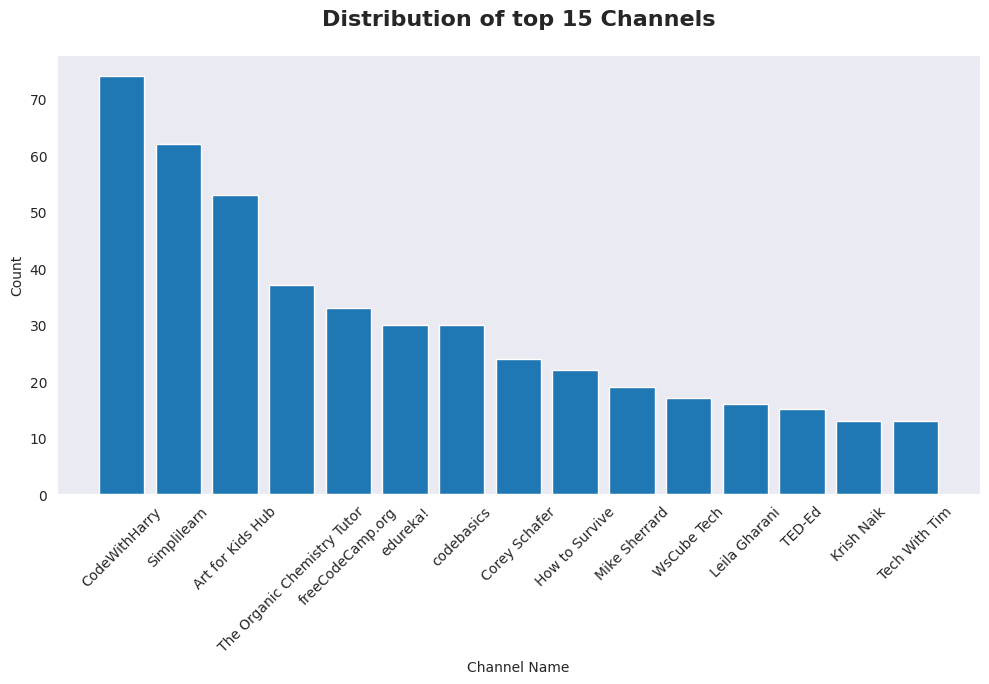

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(channel_counts.index, channel_counts.values)
plt.xlabel('Channel Name')
plt.ylabel('Count')
plt.title('Distribution of top 15 Channels', fontdict={'fontsize': 16, 'fontweight': 'bold'} , y=1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***INSIGHTS:***
**It is nice to see that the most common channels are highly related to the most common themes found on the previous steps of this study.**

------

# **STEP 07 ------------------------------------------**

# **QUANTITATIVE ANALYSIS**

## **07.01 - Correlation**

In [ ]:
columns_for_corr = ['Life_days', 'Duration_minutes', 'View_count' , 'Like_count' , 'Comment_count' , 'Channel_viewCount' , 'Channel_subscriberCount' , 'Channel_videoCount'  ]
correlation_matrix = videos_complete[columns_for_corr].corr()

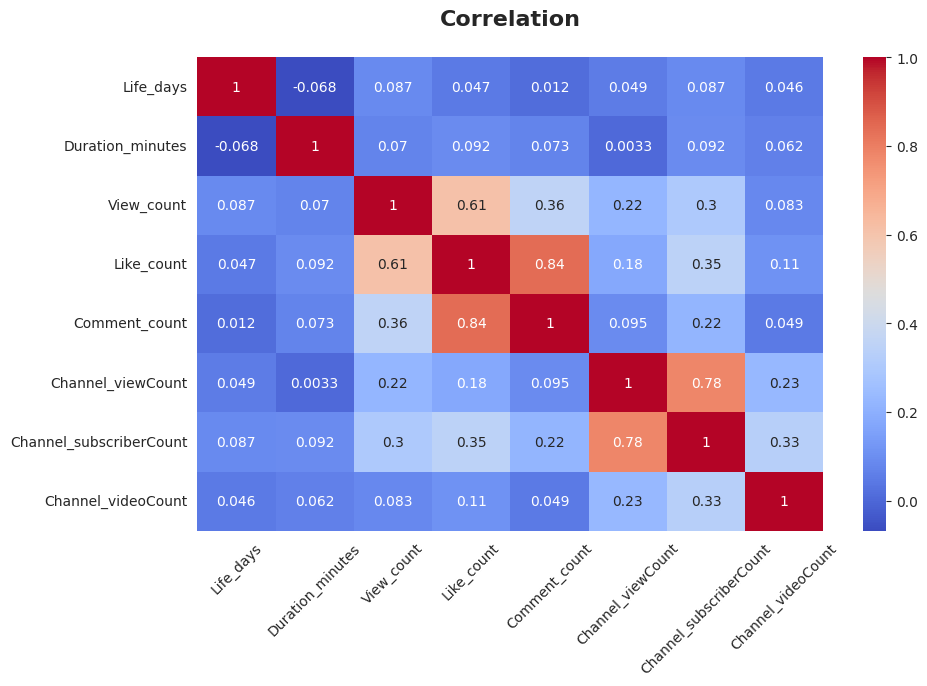

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation', fontdict={'fontsize': 16, 'fontweight': 'bold'} , y=1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***INSIGHTS:***


**The Correlation Heatmap indicates 3 higher correlations:**
- **1) 0.84 for variables Like_Count and Comment_Count**: This shows that the two types of interaction two a video are strongly related (whoever Likes the video also tends to comment on it)
- **2) 0.78 for variables Channel_viewCount and Channel_subscriberCount**: The obvious fact that a channel with more subscriebrs has more views
- **3) 0.61 for variables View_Count and Like_Count**: In the level of a video, it is also intuitive that a video with more views will have more likes.

**Surprisingly, we don't see a strong relation between the channel popularity to the video metrics. It shows that although users may be loyal to the channel, they won't view/like/comment all of the channel's videos.**


## **07.02 - Likes per video per Day for 15 top themes**

In [ ]:
top_15_themes = videos_complete['Theme'].value_counts().head(15).index
specific_languages = ['en1', 'en-US']
filtered_df = videos_complete[videos_complete['Default_language'].isin(specific_languages)]
filtered_df = filtered_df[(filtered_df['Theme'].isin(top_15_themes)) & (filtered_df['Theme']!="Irrelevant")]
average_likes_per_day = filtered_df.groupby('Theme')['Likes_per_day'].mean()
average_likes_per_day_sorted = average_likes_per_day.sort_values(ascending=False)

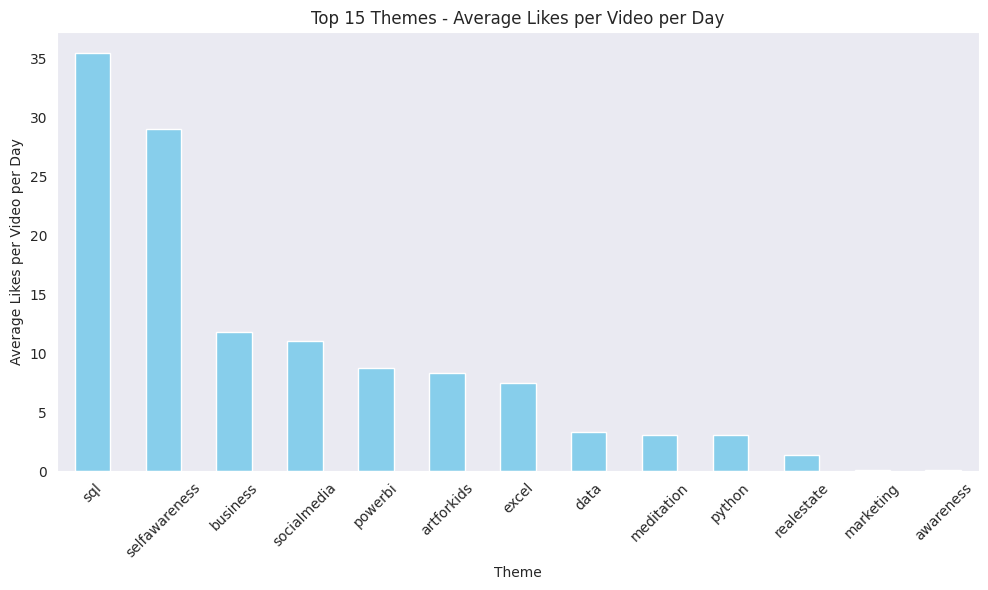

In [ ]:
plt.figure(figsize=(10, 6))
average_likes_per_day_sorted.plot(kind='bar', color='skyblue')
plt.xlabel('Theme')
plt.ylabel('Average Likes per Video per Day')
plt.title('Top 15 Themes - Average Likes per Video per Day')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

***INSIGHTS:***


**This chart shows the daily number of likes per video for the 15 most common themes. We can see a significant difference between the various themes. Videos reated to SQL and Selfawareness receive the greatest number of likes comparing to the rest of the themes.**

## **07.03 - Likes / 100views per Duration_range**

In [ ]:
dur_range = df_videos.groupby('Duration_range')[['Like_count','View_count']].sum()
dur_range['Like / 100views'] = 100 * dur_range['Like_count'] / dur_range['View_count']
dur_range

,Like_count,View_count,Like / 100views
Duration_range,,,
0-5 min,9358203.0,656266685,1.425976
5-20 min,22651051.0,1200120898,1.887397
20m to 1h,9705494.0,329809423,2.942758
1-2h,1560317.0,236917925,0.658590
2-5h,2861437.0,140290174,2.039656
>5h,3369672.0,147833229,2.279374


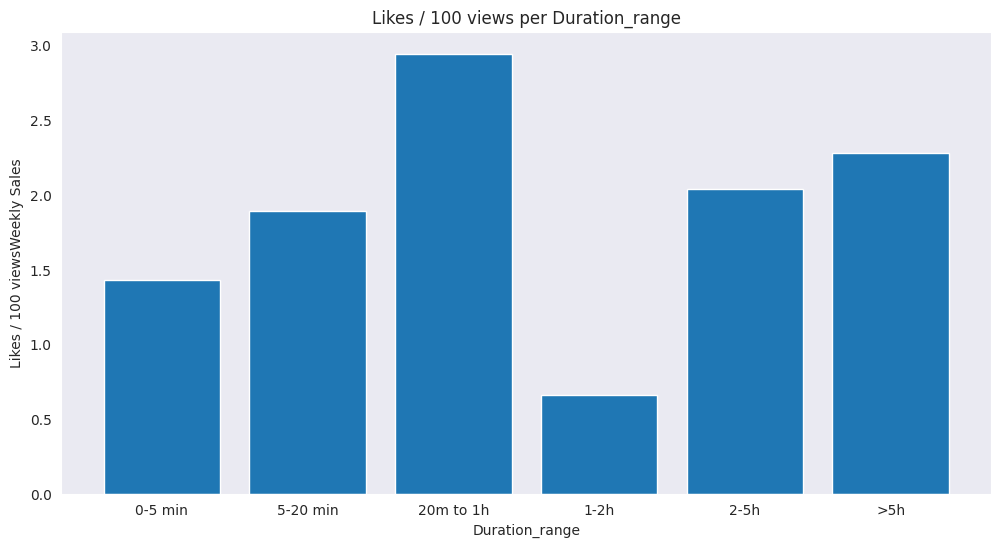

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(dur_range.index, dur_range['Like / 100views'])
plt.title('Likes / 100 views per Duration_range')
plt.xlabel('Duration_range')
plt.ylabel('Likes / 100 viewsWeekly Sales')
plt.show()

***INSIGHTS:***


**This analysis is complementar to the pie chart present in one of the first steps. While there we were analyzing absolute number of likes (before fetching the views count of each video), now we can refine the analysis and evaluate the number of likes per views (100 views) for each range of video duration. As in the first analysis, the top videos are those with duration between 20min and 1hour. However they are now followed by the longest videos (>5 hours and 2-5h). Videos with duration between 1-2hours present the lowest rate of likes.**